### Path to folders

In [1]:
folder_path = r"E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA" # Path to the folder containing the original images
detect_folder_path = r"C:\Users\felix\Documents\MT_Data\Yolo\Zone1_1"  # Folder with BBs from YOLO
csv_results = r"C:\Users\felix\Documents\MT_Data\Inpainted\Zone1_1\movingcars_csv" # Folder with CSV Results without moving cars

### Read Exifdata from UAV-Images

In [2]:
import os
import math
import re
import subprocess

# Path to the ExifTool executable
exifToolPath = "../exiftool.exe"  # Adjust if necessary

# Initialize the dictionary to store metadata
image_metadata = {}

# Filter for image files in the folder (common extensions)
valid_extensions = {'.jpg', '.jpeg', '.png'}
image_files = [f for f in os.listdir(folder_path) if os.path.splitext(f)[-1].lower() in valid_extensions]

# Process each image in the folder
for filename in image_files:
    image_path = os.path.join(folder_path, filename)
    
    # Initialize subprocess to call ExifTool
    process = subprocess.Popen([exifToolPath, image_path], stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

    # Read and parse metadata
    infoDict = {}
    for tag in process.stdout:
        line = tag.strip().split(':')  # Split each line at the ':'
        if len(line) > 1:  # Ensure valid key-value pair
            infoDict[line[0].strip()] = line[-1].strip()

    # Extract required metadata
    try:
        relAlt = float(infoDict.get("Relative Altitude", 0))  # Default to 0 if not found
        #print(relAlt)
        absAlt = float(infoDict.get("Absolute Altitude", 0))
        gpslat = infoDict.get("GPS Latitude", "")
        gpslon = infoDict.get("GPS Longitude", "")
        iw = float(infoDict.get("Image Width", 0))
        #print(iw)
        fov = infoDict.get("Field Of View", "0")
        #print(fov)
        gimbal_roll_deg = float(infoDict.get("Gimbal Roll Degree", 0))
        gimbal_yaw_deg = float(infoDict.get("Gimbal Yaw Degree", 0))
        gimbal_pitch_deg = float(infoDict.get("Gimbal Pitch Degree", 0))
        flight_yaw_deg = float(infoDict.get("Flight Yaw Degree", 0))

        
        # Parse latitude
        if gpslat:
            lat_ori = gpslat[-1]
            matches = re.findall(r'(\d+(\.\d+)?)', gpslat)
            gpslat = [float(match[0]) for match in matches]
            lat_deg, lat_min, lat_sec = gpslat
            lat_dec = abs(lat_deg) + lat_min / 60 + lat_sec / 3600
            if lat_ori == 'S':
                lat_dec = -lat_dec
        else:
            lat_dec = None

        # Parse longitude
        if gpslon:
            lon_ori = gpslon[-1]
            matches = re.findall(r'(\d+(\.\d+)?)', gpslon)
            gpslon = [float(match[0]) for match in matches]
            lon_deg, lon_min, lon_sec = gpslon
            lon_dec = abs(lon_deg) + lon_min / 60 + lon_sec / 3600
            if lon_ori == 'W':
                lon_dec = -lon_dec
        else:
            lon_dec = None

        # Calculate GSD
        if iw > 0 and relAlt < 88:
            fov_value = float(re.findall(r'\d+\.\d+', fov)[0]) if fov else 0
            fovrad = math.radians(fov_value / 2)
            gsd = (math.tan(fovrad) * relAlt) / (iw / 2)
        else:
            gsd = 0.022 # Default value

        # Store the data in a dictionary
        image_metadata[filename] = {
            'Latitude': lat_dec,
            'Longitude': lon_dec,
            'Relative Altitude': relAlt,
            'Absolute Altitude': absAlt,
            'GSD': gsd,
            "Gimbal Roll Degree": gimbal_roll_deg,
            "Gimbal Yaw Degree": gimbal_yaw_deg,
            "Gimbal Pitch Degree": gimbal_pitch_deg,
            "Flight Yaw Degree": flight_yaw_deg
        }
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Output the collected metadata
for image_name, metadata in image_metadata.items():
    print(f"Image: {image_name}")
    for key, value in metadata.items():
        print(f"  {key}: {value}")
    print()


Image: DJI_0545.JPG
  Latitude: 5.682461111111111
  Longitude: -0.03644722222222222
  Relative Altitude: 90.0
  Absolute Altitude: 116.69
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: 173.3
  Gimbal Pitch Degree: -89.9
  Flight Yaw Degree: 162.6

Image: DJI_0546.JPG
  Latitude: 5.682302777777778
  Longitude: -0.03639722222222222
  Relative Altitude: 89.9
  Absolute Altitude: 116.81
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: 173.3
  Gimbal Pitch Degree: -89.9
  Flight Yaw Degree: 162.6

Image: DJI_0547.JPG
  Latitude: 5.682175
  Longitude: -0.03635833333333333
  Relative Altitude: 89.9
  Absolute Altitude: 117.01
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: 173.3
  Gimbal Pitch Degree: -90.0
  Flight Yaw Degree: 162.5

Image: DJI_0548.JPG
  Latitude: 5.682047222222223
  Longitude: -0.036319444444444446
  Relative Altitude: 89.9
  Absolute Altitude: 117.03
  GSD: 0.022
  Gimbal Roll Degree: 0.0
  Gimbal Yaw Degree: 173.3
  Gimbal Pitch Degree

### Cross Correlation

In [5]:
import os
import numpy as np
from skimage.registration import phase_cross_correlation
from skimage import io
import math
from skimage.transform import rotate

def preprocess_image(image):
    """Preprocess the image by converting it to grayscale and normalizing."""
    if image.ndim == 3:
        image = image.mean(axis=2)  # Convert to grayscale by averaging color channels
    return image.astype(np.float32) / 255.0  # Normalize the image

def rotate_shift(shift, yaw):
    """Apply yaw rotation to the shift vector."""
    yaw_rad = math.radians(yaw)
    rotation_matrix = np.array([
        [math.cos(yaw_rad), -math.sin(yaw_rad)],
        [math.sin(yaw_rad), math.cos(yaw_rad)]
    ])
    return rotation_matrix.dot(shift)

def estimate_shift_and_rotation(image1, image2, yaw1, yaw2):
    """Estimate shift and detect rotation between two images."""
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    # Compute the initial pixel shift using cross-correlation
    shift, _, _ = phase_cross_correlation(image1, image2, upsample_factor=10)

    #print("shift",shift)

    # Detect if there’s a direction change
    yaw_diff = abs(yaw2) - abs(yaw1)
    print("abs_yaw_diff",yaw_diff)
    rotation_detected = yaw_diff > 1  # Small threshold to account for noise
    corrected_shift = shift   # Initialize corrected shift
    

    
    if rotation_detected:
        # Estimate the rotation angle based on yaw difference
        rotation_angle = yaw_diff
        
        # Rotate the second image for alignment
        image2_rotated = rotate(image2, angle=-rotation_angle, resize=False)
        
        # Recompute the shift after rotation correction
        corrected_shift, _, _ = phase_cross_correlation(image1, image2_rotated, upsample_factor=10)

    # Apply yaw correction to the shift vector
    corrected_shift = rotate_shift(corrected_shift, yaw_diff)
    rotation_angle = 0.0

    return corrected_shift, rotation_angle

def process_image_folder_with_rotation(folder_path, image_metadata):
    """
    Process all images in the folder, estimating shifts and rotations between consecutive pairs.
    
    Args:
        folder_path (str): Path to the folder containing images.
        image_metadata (dict): Metadata for images, including yaw angles.
        
    Returns:
        dict: Dictionary containing shifts and rotations for each image pair.
    """
    images = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])
    results = {}

    for i in range(len(images) - 1):
        img1_path = os.path.join(folder_path, images[i])
        img2_path = os.path.join(folder_path, images[i + 1])
        print("img1_path",img1_path)
        print("img2_path",img2_path)

        # Load the images
        image1 = io.imread(img1_path)
        image2 = io.imread(img2_path)

        if image1 is None or image2 is None:
            print(f"Error loading images: {img1_path}, {img2_path}")
            continue

        # Get yaw angles from metadata
        yaw1 = image_metadata.get(images[i], {}).get('Gimbal Yaw Degree', 0)
        yaw2 = image_metadata.get(images[i + 1], {}).get('Gimbal Yaw Degree', 0)
        print("yaw1",yaw1)
        print("yaw2",yaw2)
        
        # Estimate shift and rotation
        shift, rotation_angle = estimate_shift_and_rotation(image1, image2, yaw1, yaw2)
        
        # Store the result in the dictionary
        results[f"{images[i]}_{images[i+1]}"] = {
            "shift": {"y": shift[0], "x": shift[1]},
            "rotation_angle": rotation_angle
        }
        
        print(f"Between {images[i]} and {images[i + 1]}:")
        print(f"  Shift (y, x): {shift[0]:.2f}, {shift[1]:.2f}")
        if rotation_angle != 0.0:
            print(f"  Rotation detected: {rotation_angle:.2f} degrees")
    
    return results

# Example usage
#folder_path = "../testzone/circle"

# Process folder and save results
shift_results = process_image_folder_with_rotation(folder_path, image_metadata)

shifts_and_rotations = {
    pair: {
        'shift': data['shift'],
        'rotation_angle': data['rotation_angle']
    }
    for pair, data in shift_results.items()
}

# Print results dictionary
print("\nShifts and Rotations:")
for pair, data in shift_results.items():
    print(f"{pair}: Shift (y, x) = {data['shift']}, Rotation = {data['rotation_angle']:.2f}°")

#worked 18.4 sec for 5 pairs of images
#worked 37 sec for 10 pair of images


img1_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0545.JPG
img2_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0546.JPG
yaw1 173.3
yaw2 173.3
abs_yaw_diff 0.0
Between DJI_0545.JPG and DJI_0546.JPG:
  Shift (y, x): -720.20, -36.10
img1_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0546.JPG
img2_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0547.JPG
yaw1 173.3
yaw2 173.3
abs_yaw_diff 0.0
Between DJI_0546.JPG and DJI_0547.JPG:
  Shift (y, x): -648.90, 51.10
img1_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0547.JPG
img2_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0548.JPG
yaw1 173.3
yaw2 173.3
abs_yaw_diff 0.0
Between DJI_0547.JPG and DJI_0548.JPG:
  Shift (y, x): -659.50, 34.60
img1_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0548.JPG
img2_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0549.JPG


KeyboardInterrupt: 

In [8]:
# second try
import os
import numpy as np
from skimage.registration import phase_cross_correlation
from skimage import io
import math
from skimage.transform import rotate

def preprocess_image(image):
    """Preprocess the image by converting it to grayscale and normalizing."""
    if image.ndim == 3:
        image = image.mean(axis=2)  # Convert to grayscale by averaging color channels
    return image.astype(np.float32) / 255.0  # Normalize the image

def rotate_shift(shift, yaw):
    """Apply yaw rotation to the shift vector."""
    yaw_rad = math.radians(yaw)
    rotation_matrix = np.array([
        [math.cos(yaw_rad), -math.sin(yaw_rad)],
        [math.sin(yaw_rad), math.cos(yaw_rad)]
    ])
    return rotation_matrix.dot(shift)

def estimate_shift_and_rotation(image1, image2, yaw1, yaw2, flight_yaw1, flight_yaw2):
    """Estimate shift and detect rotation between two images."""
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    # Compute the initial pixel shift using cross-correlation
    shift, _, _ = phase_cross_correlation(image1, image2, upsample_factor=10)

    # Calculate the total yaw difference considering both gimbal and flight yaw
    total_yaw1 = yaw1 + flight_yaw1
    total_yaw2 = yaw2 + flight_yaw2
    yaw_diff = abs(total_yaw2) - abs(total_yaw1)
    print("abs_yaw_diff", yaw_diff)
    rotation_detected = yaw_diff > 1  # Small threshold to account for noise
    corrected_shift = shift   # Initialize corrected shift

    if rotation_detected:
        # Estimate the rotation angle based on yaw difference
        rotation_angle = yaw_diff
        
        # Rotate the second image for alignment
        image2_rotated = rotate(image2, angle=-rotation_angle, resize=False)
        
        # Recompute the shift after rotation correction
        corrected_shift, _, _ = phase_cross_correlation(image1, image2_rotated, upsample_factor=10)

    # Apply yaw correction to the shift vector
    corrected_shift = rotate_shift(corrected_shift, yaw_diff)
    rotation_angle = 0.0

    return corrected_shift, rotation_angle

def process_image_folder_with_rotation(folder_path, image_metadata):
    """
    Process all images in the folder, estimating shifts and rotations between consecutive pairs.
    
    Args:
        folder_path (str): Path to the folder containing images.
        image_metadata (dict): Metadata for images, including yaw angles.
        
    Returns:
        dict: Dictionary containing shifts and rotations for each image pair.
    """
    images = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])
    results = {}

    for i in range(len(images) - 1):
        img1_path = os.path.join(folder_path, images[i])
        img2_path = os.path.join(folder_path, images[i + 1])
        print("img1_path", img1_path)
        print("img2_path", img2_path)

        # Load the images
        image1 = io.imread(img1_path)
        image2 = io.imread(img2_path)

        if image1 is None or image2 is None:
            print(f"Error loading images: {img1_path}, {img2_path}")
            continue

        # Get yaw angles from metadata
        yaw1 = image_metadata.get(images[i], {}).get('Gimbal Yaw Degree', 0)
        yaw2 = image_metadata.get(images[i + 1], {}).get('Gimbal Yaw Degree', 0)
        flight_yaw1 = image_metadata.get(images[i], {}).get('Flight Yaw Degree', 0)
        flight_yaw2 = image_metadata.get(images[i + 1], {}).get('Flight Yaw Degree', 0)
        print("yaw1", yaw1)
        print("yaw2", yaw2)
        print("flight_yaw1", flight_yaw1)
        print("flight_yaw2", flight_yaw2)
        
        # Estimate shift and rotation
        shift, rotation_angle = estimate_shift_and_rotation(image1, image2, yaw1, yaw2, flight_yaw1, flight_yaw2)
        
        # Store the result in the dictionary
        results[f"{images[i]}_{images[i+1]}"] = {
            "shift": {"y": shift[0], "x": shift[1]},
            "rotation_angle": rotation_angle
        }
        
        print(f"Between {images[i]} and {images[i + 1]}:")
        print(f"  Shift (y, x): {shift[0]:.2f}, {shift[1]:.2f}")
        if rotation_angle != 0.0:
            print(f"  Rotation detected: {rotation_angle:.2f} degrees")
    
    return results

# Example usage
#folder_path = "../testzone/circle"

# Process folder and save results
shift_results = process_image_folder_with_rotation(folder_path, image_metadata)

shifts_and_rotations = {
    pair: {
        'shift': data['shift'],
        'rotation_angle': data['rotation_angle']
    }
    for pair, data in shift_results.items()
}

# Print results dictionary
print("\nShifts and Rotations:")
for pair, data in shift_results.items():
    print(f"{pair}: Shift (y, x) = {data['shift']}, Rotation = {data['rotation_angle']:.2f}°")

#worked 18.4 sec for 5 pairs of images
#worked 37 sec for 10 pair of images

img1_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0545.JPG
img2_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0546.JPG
yaw1 173.3
yaw2 173.3
flight_yaw1 162.6
flight_yaw2 162.6
abs_yaw_diff 0.0
Between DJI_0545.JPG and DJI_0546.JPG:
  Shift (y, x): -720.20, -36.10
img1_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0546.JPG
img2_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0547.JPG
yaw1 173.3
yaw2 173.3
flight_yaw1 162.6
flight_yaw2 162.5
abs_yaw_diff -0.0999999999999659
Between DJI_0546.JPG and DJI_0547.JPG:
  Shift (y, x): -648.81, 52.23
img1_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0547.JPG
img2_path E:\Data_MaterThesis\Data_Ashaiman\Raw_Images\Zone_1\100MEDIA\DJI_0548.JPG
yaw1 173.3
yaw2 173.3
flight_yaw1 162.5
flight_yaw2 162.5
abs_yaw_diff 0.0
Between DJI_0547.JPG and DJI_0548.JPG:
  Shift (y, x): -659.50, 34.60
img1_path E:\Data_MaterThesis\Data_Ashaiman\

KeyboardInterrupt: 

# Bounding Box Matching

In [13]:
import os
import csv
import pandas as pd
import numpy as np
from shapely.geometry import box
import cv2
import matplotlib.pyplot as plt


def apply_shift_and_rotation(bbox, shift, rotation_angle, image_shape):
    """Applies shift and 180-degree rotation to a bounding box."""
    x, y, width, height = bbox
    image_width, image_height = image_shape  # Ensure correctly passed as (w, h)
    
    center_x, center_y = image_width / 2, image_height / 2  # Compute image center

    # Step 1: Apply shift
    x_shifted = x + shift['x']
    y_shifted = y + shift['y']

    # Step 2: Apply 180-degree rotation if needed
    if 179 <= abs(rotation_angle) <= 181:  # Allow small variations like 180.7
        x_rotated = 2 * center_x - x_shifted
        y_rotated = 2 * center_y - y_shifted
    else:
        x_rotated, y_rotated = x_shifted, y_shifted  # No rotation applied

    return x_rotated, y_rotated, width, height


def compute_rgb_similarity(cropped1, cropped2):
    """Vergleicht zwei Bildausschnitte basierend auf Durchschnitts-RGB-Werten."""
    # Average color for RGB channels
    avg_color1 = np.mean(cropped1, axis=(0, 1))  # Mittelwert für R, G, B von Bild 1
    avg_color2 = np.mean(cropped2, axis=(0, 1))  # Mittelwert für R, G, B von Bild 2
    
    # euclidean distance between the color values
    color_distance = np.linalg.norm(avg_color1 - avg_color2)
    
    # normalize (max distance = 255 * sqrt(3) if black-white difference)
    max_distance = np.linalg.norm([255, 255, 255])
    similarity = 1 - (color_distance / max_distance)  # Ähnlichkeit zwischen 0 und 1

    # Visualisation (optional)
    """print("compute_rgb_similarity",similarity)
    plt.figure(figsize=(10, 5)) 
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cropped1, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image 1")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped2, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image 2")
    plt.axis("off")
    plt.show() """

    return similarity

def convert_bbox_format(bbox):
    x_min = bbox[0] - bbox[2] / 2
    y_min = bbox[1] - bbox[3] / 2
    return [x_min, y_min, bbox[2], bbox[3]]


def compute_iou_and_rgb(bbox1, bbox2, org_bbox2, image1, image2):

    # Convert the bounding boxes to the correct format
    bbox1 = convert_bbox_format(bbox1)
    bbox2 = convert_bbox_format(bbox2)
    org_bbox2 = convert_bbox_format(org_bbox2)
    # Shapley BB Object 
    # Cetner top left corner of the bounding box needed to work with shapely
    box1 = box(bbox1[0], bbox1[1], bbox1[0] + bbox1[2], bbox1[1] + bbox1[3])
    box2 = box(bbox2[0], bbox2[1], bbox2[0] + bbox2[2], bbox2[1] + bbox2[3])
    # Calculate the IoU
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    iou = round(intersection / union, 2) if union > 0 else 0

    if iou > 0.5:
        # Extract the bounding box regions from the images
        x1_1, y1_1, x2_1, y2_1 = int(bbox1[0]), int(bbox1[1]), int(bbox1[0] + bbox1[2]), int(bbox1[1] + bbox1[3])
        x1_2, y1_2, x2_2, y2_2 = int(org_bbox2[0]), int(org_bbox2[1]), int(org_bbox2[0] + org_bbox2[2]), int(org_bbox2[1] + org_bbox2[3])
        image1 = cv2.imread(image1)
        image2 = cv2.imread(image2)
        cropped1 = image1[y1_1:y2_1, x1_1:x2_1]
        cropped2 = image2[y1_2:y2_2, x1_2:x2_2]
        # Ensure both crops have the same shape for comparison
        if cropped1.size == 0 or cropped2.size == 0:
            print(f"Error: Empty crop for {image1} or {image2}")

        rgb_similarity = compute_rgb_similarity(cropped1, cropped2)
    else:
        rgb_similarity = 0
    return iou, rgb_similarity

def process_bounding_box_matching(detect_folder_path, image_folder_path, shift_results, iou_threshold=0.5, confidence_threshold=0.5):
    """Processes bounding box matching between previous, current, and next images using shifts."""
    shift_results = {k.lower(): v for k, v in shift_results.items()}  # Convert keys to lowercase for case-insensitive matching
    print("shift_results",shift_results)
    csv_files = sorted([f for f in os.listdir(detect_folder_path) if f.endswith('_detections.csv')])
    #print("csv_files",csv_files)
    # Set zur Speicherung bereits erkannter Bounding Boxes in Case C
    processed_bboxes = set()
    all_matching_results = []
    for i in range(len(csv_files)):
        current_file = csv_files[i]
        print("current_file",current_file)
        # Lade Bounding Boxes für das aktuelle Bild
        current_detections = pd.read_csv(os.path.join(detect_folder_path, current_file))
        current_detections = current_detections[current_detections['confidence'] >= confidence_threshold]

        image_shape = (5472, 3648)  # Ersetze dies durch die tatsächlichen Bildabmessungen, falls verfügbar

        # Verarbeite das erste Bild (nur mit Nachfolger vergleichen) case a
        if i == 0:
            next_file = csv_files[i + 1]
            next_detections = pd.read_csv(os.path.join(detect_folder_path, next_file))
            next_detections = next_detections[next_detections['confidence'] >= confidence_threshold]
            pair_key = f"{current_file.replace('_detections.csv', '').lower()}_{next_file.replace('_detections.csv', '').lower()}"
            print("pair_key",pair_key)
            if pair_key not in shift_results:
                print(f"Case A No shift/rotation data for {pair_key}. Skipping.")
                continue

            shift = shift_results[pair_key]['shift']
            rotation_angle = shift_results[pair_key]['rotation_angle']

            print(f"\nProcessing {current_file} -> {next_file} with shift: {shift} and rotation: {rotation_angle}°")
            #print(current_file, next_file, "current","next")
            image1_path = os.path.join(image_folder_path, current_file.replace('_detections.csv', ''))
            #print("image1",image1_path)
            image2_path = os.path.join(image_folder_path, next_file.replace('_detections.csv', ''))
            #print("image2",image2_path)
            bbm_file = os.path.join(detect_folder_path, f"BBM_{current_file.replace('_detections.csv', '')}.csv")
            with open(bbm_file, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["x", "y", "width", "height", "IoU"])

                for _, bbox1 in current_detections.iterrows():
                    bbox1_coords = list(bbox1[['x', 'y', 'width', 'height']].values)
                    
                    for _, bbox2 in next_detections.iterrows():
                        #bbox2_coords are the bbs from the next image
                        bbox2_coords = list(bbox2[['x', 'y', 'width', 'height']].values)
                        transformed_bbox2_coords = list(apply_shift_and_rotation(bbox2_coords, shift, rotation_angle, image_shape))

                        iou, rgb = compute_iou_and_rgb(bbox1_coords, transformed_bbox2_coords, bbox2_coords, image1_path, image2_path)
                        if iou > 0 and iou >= iou_threshold and rgb > 0.95:
                            writer.writerow([bbox1_coords[0], bbox1_coords[1], bbox1_coords[2], bbox1_coords[3], iou])
                            print("Case A",bbox1_coords, iou, rgb)

        # Verarbeite das letzte Bild (nur mit Vorgänger vergleichen) Case b 
        elif i == len(csv_files) - 1:
            prev_file = csv_files[i - 1]
            prev_detections = pd.read_csv(os.path.join(detect_folder_path, prev_file))
            prev_detections = prev_detections[prev_detections['confidence'] >= confidence_threshold]
            pair_key = f"{prev_file.replace('_detections.csv', '').lower()}_{current_file.replace('_detections.csv', '').lower()}"

            if pair_key not in shift_results:
                print(f"Case B No shift/rotation data for {pair_key}. Skipping.")
                continue

            shift = shift_results[pair_key]['shift']
            inverse_shift = {'y': -shift['y'],'x': -shift['x']}
            rotation_angle = shift_results[pair_key]['rotation_angle']
            print(f"\nProcessing {current_file} -> {prev_file} with inverted shift: {inverse_shift} and rotation: {rotation_angle}°")
            image1_path = os.path.join(image_folder_path, current_file.replace('_detections.csv', ''))
            #print("image1",image1_path)
            image2_path = os.path.join(image_folder_path, prev_file.replace('_detections.csv', ''))
            #print("image2",image2_path)
            bbm_file = os.path.join(detect_folder_path, f"BBM_{current_file.replace('_detections.csv', '')}.csv")
            with open(bbm_file, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["x", "y", "width", "height", "IoU"])

                for _, bbox1 in current_detections.iterrows():
                    bbox1_coords = list(bbox1[['x', 'y', 'width', 'height']].values)
                    #transformed_bbox1_coords = list(apply_shift_and_rotation(bbox1_coords, inverse_shift, rotation_angle, image_shape))

                    for _, bbox2 in prev_detections.iterrows():
                        bbox2_coords = list(bbox2[['x', 'y', 'width', 'height']].values)
                        transformed_bbox2_coords = list(apply_shift_and_rotation(bbox2_coords, inverse_shift, rotation_angle, image_shape))

                        iou, rgb = compute_iou_and_rgb(bbox1_coords, transformed_bbox2_coords, bbox2_coords, image1_path, image2_path)
                        if iou > 0 and iou >= iou_threshold and rgb > 0.95:
                            writer.writerow([bbox1_coords[0], bbox1_coords[1], bbox1_coords[2], bbox1_coords[3], iou])
                            print("Case B",bbox1_coords, iou, rgb)

        # Standardfall: Vergleich mit Vorgänger (Case C) und Nachfolger (Case D)
        else:
            prev_file = csv_files[i - 1]
            next_file = csv_files[i + 1]

            prev_detections = pd.read_csv(os.path.join(detect_folder_path, prev_file))
            prev_detections = prev_detections[prev_detections['confidence'] >= confidence_threshold]

            next_detections = pd.read_csv(os.path.join(detect_folder_path, next_file))
            next_detections = next_detections[next_detections['confidence'] >= confidence_threshold]

            pair_key_prev = f"{prev_file.replace('_detections.csv', '').lower()}_{current_file.replace('_detections.csv', '').lower()}"
            if pair_key_prev in shift_results:
                shift_prev = shift_results[pair_key_prev]['shift']
                inverse_shift_prev = {'y': -shift_prev['y'], 'x': -shift_prev['x']}
                rotation_angle_prev = shift_results[pair_key_prev]['rotation_angle']

                print(f"\nProcessing Case C {current_file} -> {prev_file} with inverted shift: {inverse_shift_prev} and rotation: {rotation_angle_prev}°")

                image1_path = os.path.join(image_folder_path, current_file.replace('_detections.csv', ''))
                image2_path = os.path.join(image_folder_path, prev_file.replace('_detections.csv', ''))
                bbm_file = os.path.join(detect_folder_path, f"BBM_{current_file.replace('_detections.csv', '')}.csv")

                with open(bbm_file, 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    if os.stat(bbm_file).st_size == 0:  # Kopfzeile nur schreiben, wenn Datei leer ist
                        writer.writerow(["x", "y", "width", "height", "IoU"])

                    for _, bbox1 in current_detections.iterrows():
                        bbox1_coords = tuple(bbox1[['x', 'y', 'width', 'height']].values)

                        for _, bbox2 in prev_detections.iterrows():
                            bbox2_coords = list(bbox2[['x', 'y', 'width', 'height']].values)
                            transformed_bbox2_coords = list(apply_shift_and_rotation(bbox2_coords, inverse_shift_prev, rotation_angle_prev, image_shape))

                            iou, rgb = compute_iou_and_rgb(bbox1_coords, transformed_bbox2_coords, bbox2_coords, image1_path, image2_path)

                            if iou > 0 and iou >= iou_threshold and rgb > 0.95:
                                if bbox1_coords not in processed_bboxes:  # Verhindert doppelte Einträge
                                    writer.writerow([*bbox1_coords, iou])
                                    processed_bboxes.add(bbox1_coords)  # Speicherung der Bounding Box
                                    print("Case C", bbox1_coords, iou, rgb)

            pair_key_next = f"{current_file.replace('_detections.csv', '').lower()}_{next_file.replace('_detections.csv', '').lower()}"
            if pair_key_next in shift_results:
                shift_next = shift_results[pair_key_next]['shift']
                rotation_angle_next = shift_results[pair_key_next]['rotation_angle']

                print(f"\nProcessing Case D {current_file} -> {next_file} with shift: {shift_next} and rotation: {rotation_angle_next}°")

                image1_path = os.path.join(image_folder_path, current_file.replace('_detections.csv', ''))
                image2_path = os.path.join(image_folder_path, next_file.replace('_detections.csv', ''))

                with open(bbm_file, 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile)

                    for _, bbox1 in current_detections.iterrows():
                        bbox1_coords = tuple(bbox1[['x', 'y', 'width', 'height']].values)

                        # **Check: Wurde bbox1 bereits in Case C gespeichert?**
                        if bbox1_coords in processed_bboxes:
                            continue  # Überspringe diese Bounding Box in Case D

                        for _, bbox2 in next_detections.iterrows():
                            bbox2_coords = list(bbox2[['x', 'y', 'width', 'height']].values)
                            transformed_bbox2_coords = list(apply_shift_and_rotation(bbox2_coords, shift_next, rotation_angle_next, image_shape))

                            iou, rgb = compute_iou_and_rgb(bbox1_coords, transformed_bbox2_coords, bbox2_coords, image1_path, image2_path)

                            if iou > 0 and iou >= iou_threshold and rgb > 0.95:
                                writer.writerow([*bbox1_coords, iou])
                                print("Case D", bbox1_coords, iou, rgb)

process_bounding_box_matching(
    detect_folder_path=detect_folder_path,
    image_folder_path=folder_path,
    shift_results=shift_results,
    iou_threshold=0.5,  # IoU-Schwellenwert
    confidence_threshold=0.5  # Vertrauensschwellenwert
)

shift_results {'dji_0707.jpg_dji_0708.jpg': {'shift': {'y': np.float64(-710.2999877929688), 'x': np.float64(-31.0)}, 'rotation_angle': 0.0}, 'dji_0708.jpg_dji_0709.jpg': {'shift': {'y': np.float64(-689.9000244140625), 'x': np.float64(38.20000076293945)}, 'rotation_angle': 0.0}, 'dji_0709.jpg_dji_0710.jpg': {'shift': {'y': np.float64(-713.7999877929688), 'x': np.float64(16.0)}, 'rotation_angle': 0.0}, 'dji_0710.jpg_dji_0711.jpg': {'shift': {'y': np.float64(-711.7999877929688), 'x': np.float64(-11.0)}, 'rotation_angle': 0.0}}
current_file DJI_0707.JPG_detections.csv
pair_key dji_0707.jpg_dji_0708.jpg

Processing DJI_0707.JPG_detections.csv -> DJI_0708.JPG_detections.csv with shift: {'y': np.float64(-710.2999877929688), 'x': np.float64(-31.0)} and rotation: 0.0°
Case A [1560, 1311, 282, 193] 0.74 0.9790391972521529
Case A [401, 438, 239, 171] 0.53 0.997855374035068
Case A [884, 347, 265, 182] 0.56 0.9884149612891837
Case A [3078, 2445, 205, 125] 0.92 0.9810407898685852
Case A [1008, 1607,

# Visualisation with YOLO BBs


Verarbeite Bild: detected_DJI_0711.JPG


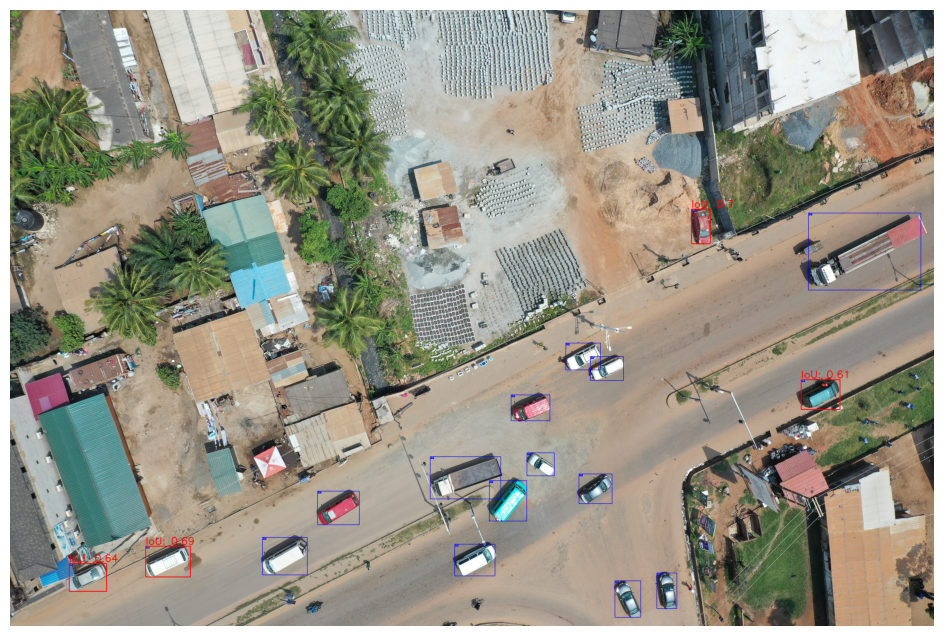


Verarbeite Bild: detected_DJI_0710.JPG


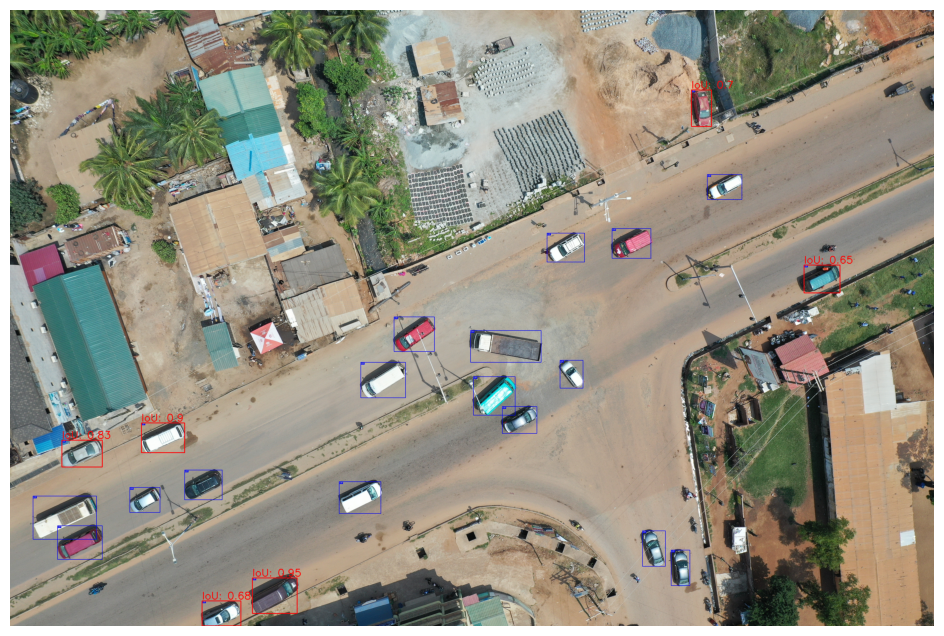


Verarbeite Bild: detected_DJI_0709.JPG


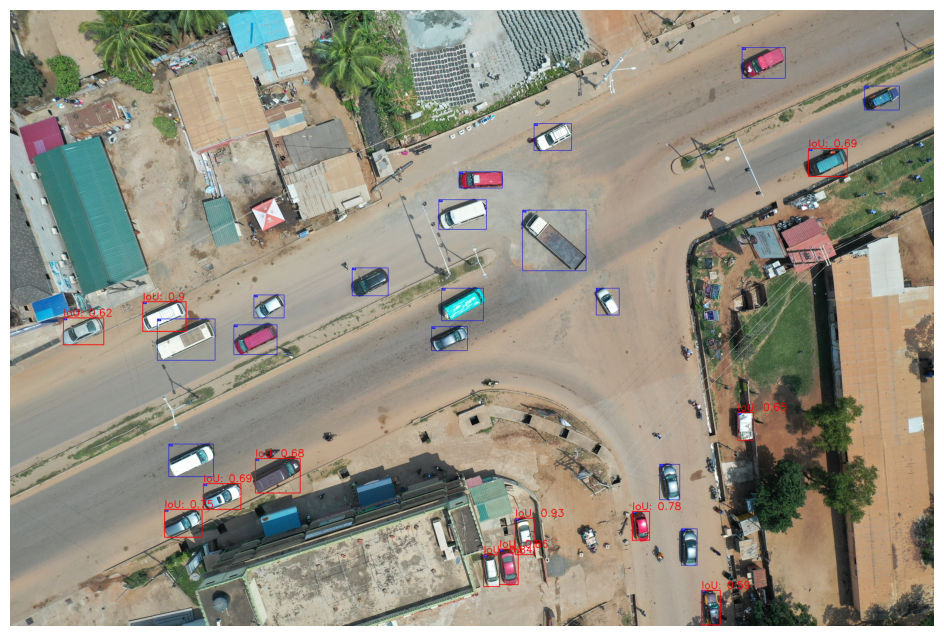


Verarbeite Bild: detected_DJI_0708.JPG


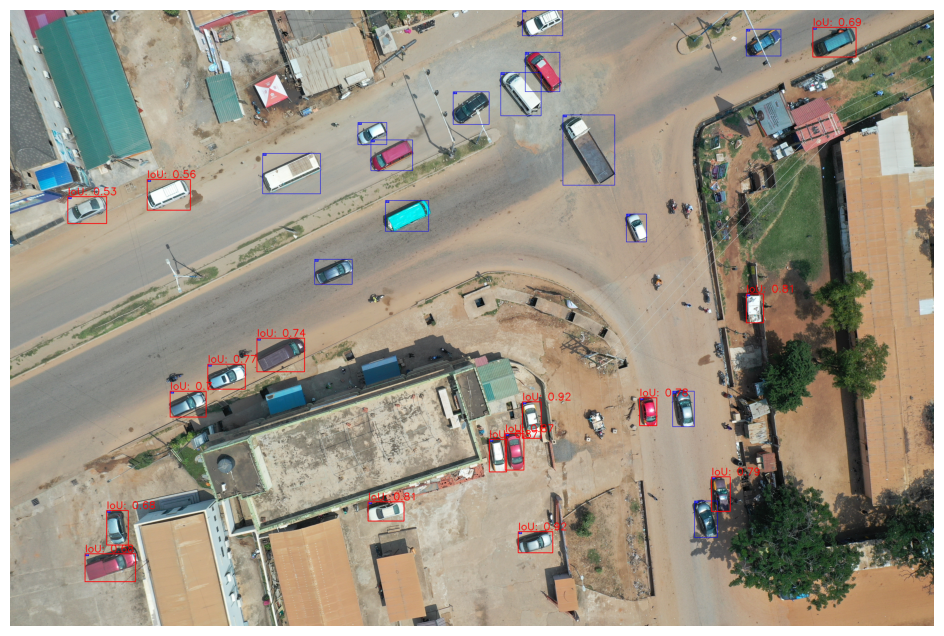


Verarbeite Bild: detected_DJI_0707.JPG


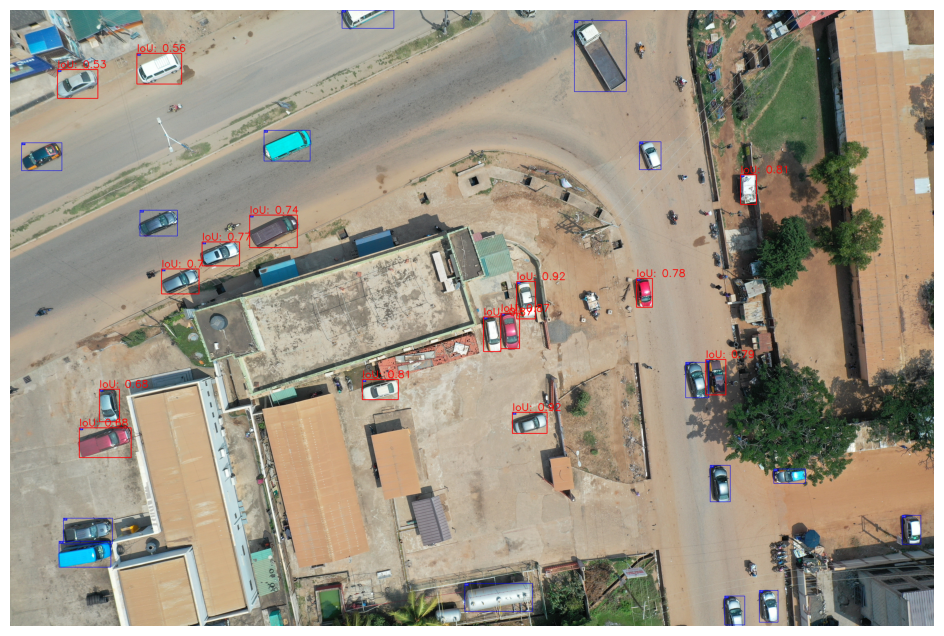

In [14]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

def draw_bboxes_from_csv(image_path, csv_path):
    # Lade das Bild
    image = cv2.imread(image_path)
    if image is None:
        print(f"Fehler beim Laden des Bildes: {image_path}")
        return

    # Hole die Dimensionen des Bildes
    height, width, _ = image.shape

    # Lade die CSV-Datei mit den Bounding Boxes
    if not os.path.exists(csv_path):
        print(f"CSV-Datei nicht gefunden: {csv_path}")
        return
    
    df = pd.read_csv(csv_path)
    #print(df.head())  # Ausgabe der ersten Zeilen der CSV-Datei zur Überprüfung

    # Zeichne jede Bounding Box auf das Bild
    for _, row in df.iterrows():
        try:
            # Werte aus der CSV
            x = row['x']
            y = row['y']
            box_width = row['width']
            box_height = row['height']
            iou = round(row['IoU'], 2)  # Runden des IoU-Werts auf 2 Nachkommastellen
            #print("x",x,"y",y,"box_width",box_width,"box_height",box_height,"iou",iou)

            # Berechne die Koordinaten der linken oberen Ecke und der unteren rechten Ecke
            x1 = int(x - box_width / 2)  # x1 ist die linke obere Ecke
            y1 = int(y - box_height / 2)  # y1 ist die obere linke Ecke
            x2 = int(x + box_width / 2)  # x2 ist die rechte untere Ecke
            y2 = int(y + box_height / 2)  # y2 ist die rechte untere Ecke
            #print("x1",x1,"y1",y1,"x2",x2,"y2",y2)
            # Rechteck zeichnen (x1, y1 ist die obere linke Ecke, x2, y2 ist die untere rechte Ecke)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Blaue Farbe und Dicke = 3

            # Füge den IoU-Wert als Text neben der Bounding Box hinzu
            label = f"IoU: {iou}"
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
        except KeyError as e:
            print(f"KeyError: {e} in row {row}")

    # Konvertiere das Bild nach RGB für Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Zeige das Bild an
    plt.figure(figsize=(12, 8))  # Setzt eine größere Figurgröße für bessere Anzeige
    plt.imshow(image_rgb)
    plt.axis('off')  # Achsen ausschalten
    plt.show()


def process_folder(image_folder, csv_folder):
    # Liste aller Bilddateien im Ordner
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg',".JPG", '.png'))]

    # Sortiere die Bilder umgekehrt, sodass das letzte Bild zuerst kommt
    image_files.sort(reverse=True)

    for image_file in image_files:
        # Vollständiger Pfad zum Bild
        image_path = os.path.join(image_folder, image_file)
        #print(image_path)
        
        # Entferne den "detected_" Präfix aus dem Bildnamen
        csv_file_name = image_file.replace("detected_", "")
        
        # Erzeuge den Pfad zur zugehörigen CSV-Datei
        csv_file = f"BBM_{csv_file_name}.csv"  # Beispiel für den CSV-Dateinamen
        csv_path = os.path.join(csv_folder, csv_file)
        #print(csv_path)

        print(f"\nVerarbeite Bild: {image_file}")
        draw_bboxes_from_csv(image_path, csv_path)



process_folder(detect_folder_path, detect_folder_path)


### Compare&Save moving Cars BBs to CSV

In [16]:
import os
import pandas as pd
import re

# Pfade anpassen
#ordner_pfad = "Pfad/zum/Ordner"  # Hauptordner mit allen CSV-Dateien

#ergebnis_ordner_pfad = "Pfad/zum/Ergebnisordner"

# Sicherstellen, dass der Ergebnisordner existiert
os.makedirs(csv_results, exist_ok=True)

# Alle Dateien im Ordner holen
data = os.listdir(detect_folder_path)

# Filtere *_detections.csv und BBM_*.csv Dateien
detections_files = [f for f in data if f.endswith("_detections.csv")]
bbm_files = [f for f in data if f.startswith("BBM_") and f.endswith(".csv")]

# Erzeuge eine Zuordnung nach Bildziffern
detections_dict = {re.sub(r'_detections.csv$', '', f): f for f in detections_files}
bbm_dict = {re.sub(r'BBM_', '', f).replace('.csv', ''): f for f in bbm_files}

# Nur passende Paare verarbeiten
for id, detection_file in detections_dict.items():
    if id in bbm_dict:
        bbm_file = bbm_dict[id]

        csv1_pfad = os.path.join(detect_folder_path, detection_file)
        csv2_pfad = os.path.join(detect_folder_path, bbm_file)

        # CSV-Dateien laden
        df1 = pd.read_csv(csv1_pfad)
        df2 = pd.read_csv(csv2_pfad)

        # Relevante Spalten (nur x und y) extrahieren
        set1 = set(zip(df1["x"], df1["y"]))
        set2 = set(zip(df2["x"], df2["y"]))

        # Einträge, die nur in der ersten Datei vorkommen
        unique_entries = set1 - set2

        # Falls keine Unterschiede, nächste Datei verarbeiten
        if not unique_entries:
            print(f"Keine einzigartigen Einträge für {id}.")
            continue
        
        # Daten für die Ausgabe filtern
        df1_filtered = df1[df1.apply(lambda row: (row["x"], row["y"]) in unique_entries, axis=1)]

        # Ergebnisdatei speichern
        ergebnis_datei = os.path.join(csv_results, f"movingcar_BB_{id}.csv")
        df1_filtered.to_csv(ergebnis_datei, index=False)
        print(f"Vergleich für {id} save {ergebnis_datei}")

print("Done!")


Vergleich für DJI_0707.JPG save ..\testzone\Intersection\results\movingcar_BB_DJI_0707.JPG.csv
Vergleich für DJI_0708.JPG save ..\testzone\Intersection\results\movingcar_BB_DJI_0708.JPG.csv
Vergleich für DJI_0709.JPG save ..\testzone\Intersection\results\movingcar_BB_DJI_0709.JPG.csv
Vergleich für DJI_0710.JPG save ..\testzone\Intersection\results\movingcar_BB_DJI_0710.JPG.csv
Vergleich für DJI_0711.JPG save ..\testzone\Intersection\results\movingcar_BB_DJI_0711.JPG.csv
Done!
